In [2]:
# Manejo de datos
import pandas as pd
import numpy as np
# Pruebas para aplicar el modelo
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
# Preprocesamiento y modelo
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Gráficos
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

In [3]:
# Cargar el archivo CSV
employee = pd.read_csv('data\\clean.csv')

Las variables numéricas son:
- Age, DailyRate, DistanceFromHome, HourlyRate, MonthlyIncome, MonthlyRate, NumCompaniesWorked, PercentSalaryHike, StandardHours, TotalWorkingYears, TrainingTimesLastYear, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager

Un total de 15 variables. 

In [4]:
# Seleccionar las columnas numéricas relevantes para el PCA
pca_columns = [
    "Age", "DailyRate", "DistanceFromHome", "HourlyRate", "MonthlyIncome", 
    "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike", "TotalWorkingYears", 
    "TrainingTimesLastYear", "YearsAtCompany", "YearsInCurrentRole", 
    "YearsSinceLastPromotion", "YearsWithCurrManager", "StandardHours"
]
numeric_data = employee[pca_columns]
numeric_data.head()

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,StandardHours
0,41,1102,1,94,5993,19479,8,11,8,0,6,4,0,5,80
1,49,279,8,61,5130,24907,1,23,10,3,10,7,1,7,80
2,37,1373,2,92,2090,2396,6,15,7,3,0,0,0,0,80
3,33,1392,3,56,2909,23159,1,11,8,3,8,7,3,0,80
4,27,591,2,40,3468,16632,9,12,6,3,2,2,2,2,80


Se procederá a conocer si las variables numéricas poseen varios datos únicos, se correrá el siguiente código. 

In [5]:
unique_dict = {}

for column in numeric_data.columns:
    unique_dict[column] = numeric_data[column].unique()

# Mostrar los resultados
for column, unique_val in unique_dict.items():
    print(f"Valores unicos por columna {column}:")
    print(unique_val)
    print()

Valores unicos por columna Age:
[41 49 37 33 27 32 59 30 38 36 35 29 31 34 28 22 53 24 21 42 44 46 39 43
 50 26 48 55 45 56 23 51 40 54 58 20 25 19 57 52 47 18 60]

Valores unicos por columna DailyRate:
[1102  279 1373 1392  591 1005 1324 1358  216 1299  809  153  670 1346
  103 1389  334 1123 1219  371  673 1218  419  391  699 1282 1125  691
  477  705  924 1459  125  895  813 1273  869  890  852 1141  464 1240
 1357  994  721 1360 1065  408 1211 1229  626 1434 1488 1097 1443  515
  853 1142  655 1115  427  653  989 1435 1223  836 1195 1339  664  318
 1225 1328 1082  548  132  746  776  193  397  945 1214  111  573 1153
 1400  541  432  288  669  530  632 1334  638 1093 1217 1353  120  682
  489  807  827  871  665 1040 1420  240 1280  534 1456  658  142 1127
 1031 1189 1354 1467  922  394 1312  750  441  684  249  841  147  528
  594  470  957  542  802 1355 1150 1329  959 1033 1316  364  438  689
  201 1427  857  933 1181 1395  662 1436  194  967 1496 1169 1145  630
  303 1256  440 

StandardHours no posee diferentes valores, por lo cual no se tomará el cuenta para la construcción del modelo.

In [6]:
numeric_data = numeric_data.drop(columns=['StandardHours'])
numeric_data.head()

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1102,1,94,5993,19479,8,11,8,0,6,4,0,5
1,49,279,8,61,5130,24907,1,23,10,3,10,7,1,7
2,37,1373,2,92,2090,2396,6,15,7,3,0,0,0,0
3,33,1392,3,56,2909,23159,1,11,8,3,8,7,3,0
4,27,591,2,40,3468,16632,9,12,6,3,2,2,2,2


### Test de Esfericidad de Bartlett
Antes de aplicar el modelo, se aplicará el test de esfericidad de Bartlett el cual evalúa si las variables están altamente correlacionadas.

$H_0$: La matriz de correlación es igual a la matriz identidad

In [7]:
# Prueba de esfericidad de Bartlett
bartlett_test, bartlett_p_value = calculate_bartlett_sphericity(numeric_data)
print("Prueba de esfericidad de Bartlett:")
print("Estadístico:", bartlett_test)
print("Valor p:", bartlett_p_value)

Prueba de esfericidad de Bartlett:
Estadístico: 6889.979963710002
Valor p: 0.0


El p-valor es menor que 0.05, por lo que se rechaza la hipótesis nula. Se acepta la hipótesis alternativa la cual indica que hay correlación entre las variables, es decir que se puede aplicar el modelo PCA

In [8]:
# Índice de KMO
kmo_all, kmo_model = calculate_kmo(numeric_data)
print("\nÍndice KMO:", kmo_model)


Índice KMO: 0.815694586818594


Dado que el valor entra en el rango entre 0.80 a 0.89, categorizado como meritorio, es adecuado aplicar el PCA.

In [9]:
numeric_data.shape

(1470, 14)

## Construcción del modelo

In [10]:
#Se escalan los datos y luego se le aplica PCA
pca_pipe = make_pipeline(StandardScaler(),PCA()) 
#Se ajusta el modelo
pca_pipe.fit(numeric_data) 
#Se extrae el modelo del pipeline
modelo_pca = pca_pipe.named_steps['pca']

#Se convierte el arreglo en data frame
pca_result = pd.DataFrame(
    data = modelo_pca.components_,
    columns = numeric_data.columns,
    index = ['PC1','PC2','PC3','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15']
)

In [11]:
pca_result

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
PC1,0.280157,-0.006815,0.004812,-0.011289,0.360623,0.001123,0.030992,-0.015351,0.415286,-0.010993,0.443444,0.391353,0.344322,0.386171
PC2,0.472170,0.077962,-0.041565,0.062668,0.290395,0.086158,0.560133,-0.004618,0.318116,-0.092458,-0.213080,-0.279424,-0.198658,-0.295139
PC3,-0.003362,0.207301,0.664885,0.352148,-0.052415,-0.020312,-0.005628,0.465842,-0.009368,-0.409028,-0.002116,0.048112,-0.003993,0.031746
PC5,0.004488,-0.609570,0.306132,-0.255816,0.025332,0.664086,-0.041876,-0.055690,0.007028,-0.138279,-0.010571,-0.038785,0.027660,-0.034460
PC6,0.039563,0.211569,-0.048942,-0.602292,0.034942,0.101166,-0.017786,0.698727,0.024159,0.293982,-0.024921,0.004927,-0.019935,-0.021898
PC7,0.058710,0.130624,0.176841,0.481632,0.033266,0.371271,-0.101256,0.008299,0.025256,0.751634,0.001938,-0.014571,-0.018689,-0.028659
PC8,-0.098197,0.715405,0.031448,-0.221010,-0.012273,0.482943,-0.032990,-0.376210,-0.029512,-0.217565,0.005336,0.062087,0.022129,0.011526
PC9,0.059277,0.027706,0.652172,-0.401421,0.036859,-0.404489,0.033558,-0.383353,0.043982,0.296226,-0.018626,-0.054208,-0.038505,-0.041762
PC10,-0.183115,-0.028707,0.037738,-0.004675,-0.377381,0.056691,0.775797,0.012191,-0.196663,0.130786,-0.001551,0.201595,0.306726,0.161414
PC11,0.005034,0.040304,0.002339,0.018010,0.104651,-0.044889,-0.129587,0.019569,-0.038586,-0.017811,-0.104225,-0.271684,0.845951,-0.407140


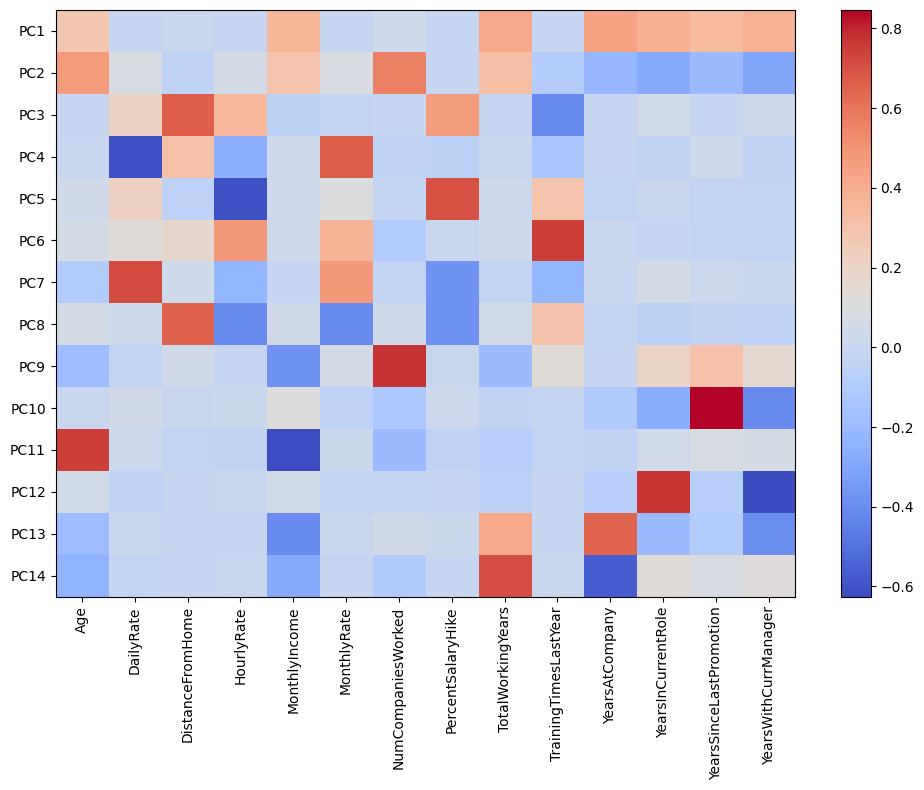

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8)) 
componentes = modelo_pca.components_

cax = ax.imshow(componentes, cmap="coolwarm", aspect="auto")  # Muestra los coeficientes de los componentes principales en una matriz de colores
ax.set_xticks(range(len(numeric_data.columns)))
ax.set_xticklabels(numeric_data.columns, rotation=90)  # etiquetas de las variables en el eje X
ax.set_yticks(range(modelo_pca.n_components_))
ax.set_yticklabels([f"PC{i+1}" for i in range(modelo_pca.n_components_)])  # componentes principales en el eje Y

# Configuración adicional
plt.colorbar(cax, ax=ax, orientation="vertical")  # Muestra una barra de color para interpretar la intensidad
ax.grid(False)  # Oculta la cuadrícula
plt.tight_layout()  # Ajusta el diseño automáticamente

plt.show()


In [13]:
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.28691241 0.1178718  0.07632173 0.07515143 0.07210077 0.07088985
 0.06809641 0.0655355  0.05160467 0.03790696 0.03356039 0.02023023
 0.01381314 0.0100047 ]


Text(0, 0.5, 'Por. varianza explicada')

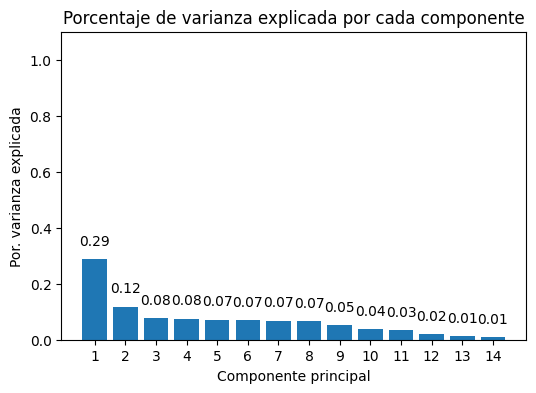

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(numeric_data.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada')

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.28691241 0.40478422 0.48110594 0.55625738 0.62835815 0.699248
 0.7673444  0.8328799  0.88448457 0.92239154 0.95595193 0.97618216
 0.9899953  1.        ]


Text(0, 0.5, 'Por. varianza acumulada')

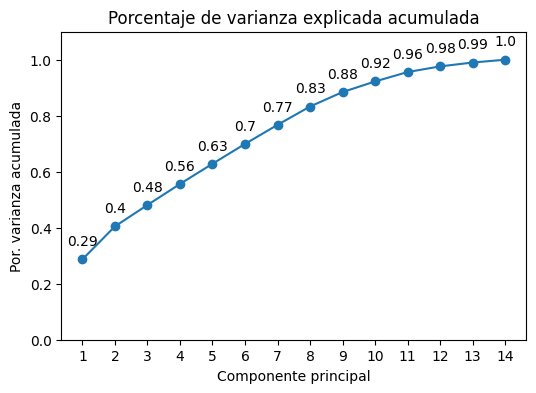

In [15]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(numeric_data.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(numeric_data.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada')

# Preparación de información
La información obtenida en el PCA puede ser aplicada en otros modelos. Aquí se realiza este proceso.

Como se puede observar las componentes que explican la mayor varianza realmente son la primera componente con un 28.69% y la segunda componente con 11.79%. Sin embargo estas representan el 40.48% de la variaza acumulada.

In [17]:
numeric_data.shape

(1470, 14)

In [18]:
# Extraer las dos primeras componentes principales
## trabajando con una copia de los datos
numeric_data2 = numeric_data.copy() 
## Se escalan los datos y se le aplica PCA
numeric_data2 = StandardScaler().fit_transform(numeric_data2) 
pca_transformed_data = modelo_pca.transform(numeric_data2)[:, :2]
pca_df = pd.DataFrame(data=pca_transformed_data, columns=['PC1', 'PC2'])
print(pca_df.head())
print(pca_df.shape)

        PC1       PC2
0 -0.243127  1.805911
1  0.854579 -0.381203
2 -2.199023  1.413783
3 -0.571040 -0.682526
4 -1.568219  0.965767
(1470, 2)


In [19]:
# Variables categóricas
employee_cual = employee.copy()
employee_cual = employee_cual.drop(columns=pca_columns) # Se eliminan las columnas numéricas
employee_cual = employee_cual.drop(columns=["EmployeeCount", "Over18","EmployeeNumber"]) # Estas columnas no aportan información
final_data = pd.concat([pca_df, employee_cual.reset_index(drop=True)], axis=1) # Se unen los datos
final_data.head()

,PC1,PC2,Attrition,BusinessTravel,Department,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,OverTime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,WorkLifeBalance
0,-0.243127,1.805911,Yes,Travel_Rarely,Sales,2,Life Sciences,2,Female,3,2,Sales Executive,4,Single,Yes,3,1,0,1
1,0.854579,-0.381203,No,Travel_Frequently,Research & Development,1,Life Sciences,3,Male,2,2,Research Scientist,2,Married,No,4,4,1,3
2,-2.199023,1.413783,Yes,Travel_Rarely,Research & Development,2,Other,4,Male,2,1,Laboratory Technician,3,Single,Yes,3,2,0,3
3,-0.571040,-0.682526,No,Travel_Frequently,Research & Development,4,Life Sciences,4,Female,3,1,Research Scientist,3,Married,Yes,3,3,0,3
4,-1.568219,0.965767,No,Travel_Rarely,Research & Development,1,Medical,1,Male,3,1,Laboratory Technician,2,Married,No,3,4,1,3


In [20]:
cualitativas_columns = employee_cual.columns[1:] # no seleccionar la variable objetivo (Attrition)
cualitativas_columns

Index(['BusinessTravel', 'Department', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'WorkLifeBalance'],
      dtype='object')

In [21]:
# Codificar las variables cualitativas
final_data = pd.get_dummies(final_data, columns=cualitativas_columns)
final_data.head()

,PC1,PC2,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_1,...,RelationshipSatisfaction_3,RelationshipSatisfaction_4,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,WorkLifeBalance_1,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4
0,-0.243127,1.805911,Yes,False,False,True,False,False,True,False,...,False,False,True,False,False,False,True,False,False,False
1,0.854579,-0.381203,No,False,True,False,False,True,False,True,...,False,True,False,True,False,False,False,False,True,False
2,-2.199023,1.413783,Yes,False,False,True,False,True,False,False,...,False,False,True,False,False,False,False,False,True,False
3,-0.571040,-0.682526,No,False,True,False,False,True,False,False,...,True,False,True,False,False,False,False,False,True,False
4,-1.568219,0.965767,No,False,False,True,False,True,False,True,...,False,True,False,True,False,False,False,False,True,False


In [22]:
final_data.to_csv('data\\pca_result.csv')